In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Load dataset (assuming CSV format)
def load_data(filepath):
    df = pd.read_csv('Daily Data (1).csv')
    
    # Create datetime index
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df.set_index('date', inplace=True)
    df.drop(columns=['Year', 'Month', 'Day'], inplace=True)
    
    # Check for missing values
    print("Missing values per column:")
    print(df.isnull().sum())
    
    # Forward fill missing values (alternative: interpolate)
    df.ffill(inplace=True)
    
    return df

# Feature engineering
def add_features(df, window_size=7):
    # Rolling statistics for solar features
    df['solar_flare_ma'] = df['Solar Flare'].rolling(window=window_size).mean()
    df['sunspot_ma'] = df['Sunspot Number'].rolling(window=window_size).mean()
    
    # Lag features
    for lag in [1, 2, 3, 7]:
        df[f'solar_flare_lag_{lag}'] = df['Solar Flare'].shift(lag)
        df[f'sunspot_lag_{lag}'] = df['Sunspot Number'].shift(lag)
    
    # Seasonal features
    df['day_of_year'] = df.index.dayofyear
    df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Drop rows with NaN created by rolling/lag features
    df.dropna(inplace=True)
    
    return df

# Normalization
def normalize_data(df, target_col='LST'):
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[[target_col]]
    
    # Normalize features (MinMax for LST, Standard for others)
    feature_scaler = StandardScaler()
    X_scaled = feature_scaler.fit_transform(X)
    
    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y)
    
    return X_scaled, y_scaled, feature_scaler, target_scaler

# Create sequences for time series
def create_sequences(X, y, seq_length=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [31]:
# Custom Dataset
class LSTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Hybrid CNN-LSTM Model with Attention
class LSTPredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super(LSTPredictionModel, self).__init__()
        
        # CNN for local pattern extraction
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )
        
        # LSTM for temporal dependencies
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Softmax(dim=1)
        )
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(64 + hidden_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        # CNN branch
        cnn_input = x.permute(0, 2, 1)  # (batch, features, seq_len)
        cnn_out = self.cnn(cnn_input)
        
        # LSTM branch
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size)
        
        # Attention
        attention_weights = self.attention(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Concatenate features
        combined = torch.cat([cnn_out, context_vector], dim=1)
        
        # Regression
        output = self.regressor(combined)
        return output

In [33]:
def train_model(model, train_loader, val_loader, epochs=100, patience=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    
    best_loss = float('inf')
    early_stop_counter = 0
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * X_batch.size(0)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
        
        # Calculate average losses
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Early stopping and learning rate scheduling
        if val_loss < best_loss:
            best_loss = val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        scheduler.step(val_loss)
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, history

In [35]:
def evaluate_model(model, test_loader, target_scaler):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            
            y_true.extend(y_test.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
    
    # Inverse transform predictions
    y_true = target_scaler.inverse_transform(np.array(y_true).reshape(-1, 1))
    y_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    correlation = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]
    
    print(f'MAE: {mae:.2f}')
    print(f'R² Score: {r2:.2f}')
    print(f'Correlation Coefficient: {correlation:.2f}')
    
    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual LST')
    plt.plot(y_pred, label='Predicted LST', alpha=0.7)
    plt.title('Actual vs Predicted Land Surface Temperature')
    plt.xlabel('Samples')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()
    
    # Scatter plot
    plt.figure(figsize=(8, 8))
    sns.regplot(x=y_true.flatten(), y=y_pred.flatten())
    plt.xlabel('Actual LST')
    plt.ylabel('Predicted LST')
    plt.title('Predicted vs Actual Values')
    plt.show()
    
    return y_true, y_pred

Missing values per column:
LST               0
Solar Flare       0
Sunspot Number    0
dtype: int64


C:\Users\Redwan Ahmed Tamim\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/200: 100%|██████████| 88/88 [00:36<00:00,  2.43it/s]


Epoch 1: Train Loss: 0.1209, Val Loss: 0.1287


Epoch 2/200: 100%|██████████| 88/88 [00:10<00:00,  8.50it/s]


Epoch 2: Train Loss: 0.0628, Val Loss: 0.0316


Epoch 3/200: 100%|██████████| 88/88 [00:09<00:00,  9.50it/s]


Epoch 3: Train Loss: 0.0486, Val Loss: 0.0657


Epoch 4/200: 100%|██████████| 88/88 [00:09<00:00,  9.10it/s]


Epoch 4: Train Loss: 0.0393, Val Loss: 0.0792


Epoch 5/200: 100%|██████████| 88/88 [00:10<00:00,  8.20it/s]


Epoch 5: Train Loss: 0.0364, Val Loss: 0.0949


Epoch 6/200: 100%|██████████| 88/88 [00:12<00:00,  7.11it/s]


Epoch 6: Train Loss: 0.0334, Val Loss: 0.0750


Epoch 7/200: 100%|██████████| 88/88 [00:12<00:00,  6.94it/s]


Epoch 7: Train Loss: 0.0318, Val Loss: 0.0526


Epoch 8/200: 100%|██████████| 88/88 [00:12<00:00,  7.30it/s]


Epoch 8: Train Loss: 0.0312, Val Loss: 0.0618


Epoch 9/200: 100%|██████████| 88/88 [00:09<00:00,  8.80it/s]


Epoch 9: Train Loss: 0.0294, Val Loss: 0.0521


Epoch 10/200: 100%|██████████| 88/88 [00:09<00:00,  8.95it/s]


Epoch 10: Train Loss: 0.0290, Val Loss: 0.0485


Epoch 11/200: 100%|██████████| 88/88 [00:08<00:00, 10.28it/s]


Epoch 11: Train Loss: 0.0286, Val Loss: 0.0398


Epoch 12/200: 100%|██████████| 88/88 [00:09<00:00,  8.89it/s]


Epoch 12: Train Loss: 0.0281, Val Loss: 0.0386


Epoch 13/200: 100%|██████████| 88/88 [00:10<00:00,  8.06it/s]


Epoch 13: Train Loss: 0.0280, Val Loss: 0.0333


Epoch 14/200: 100%|██████████| 88/88 [00:08<00:00,  9.95it/s]


Epoch 14: Train Loss: 0.0273, Val Loss: 0.0349


Epoch 15/200: 100%|██████████| 88/88 [00:11<00:00,  7.96it/s]


Epoch 15: Train Loss: 0.0264, Val Loss: 0.0320


Epoch 16/200: 100%|██████████| 88/88 [00:09<00:00,  8.97it/s]


Epoch 16: Train Loss: 0.0267, Val Loss: 0.0324


Epoch 17/200: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s]


Epoch 17: Train Loss: 0.0262, Val Loss: 0.0320
Early stopping at epoch 17


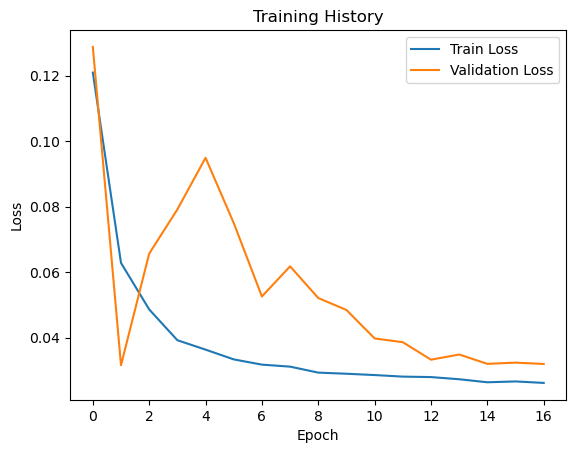

MAE: 6.30
R² Score: -1.42
Correlation Coefficient: -0.20


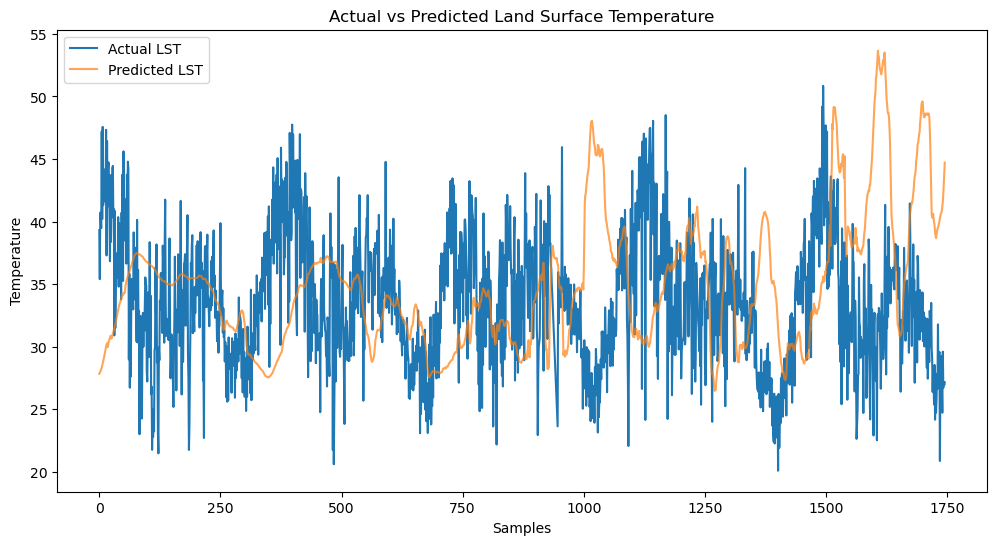

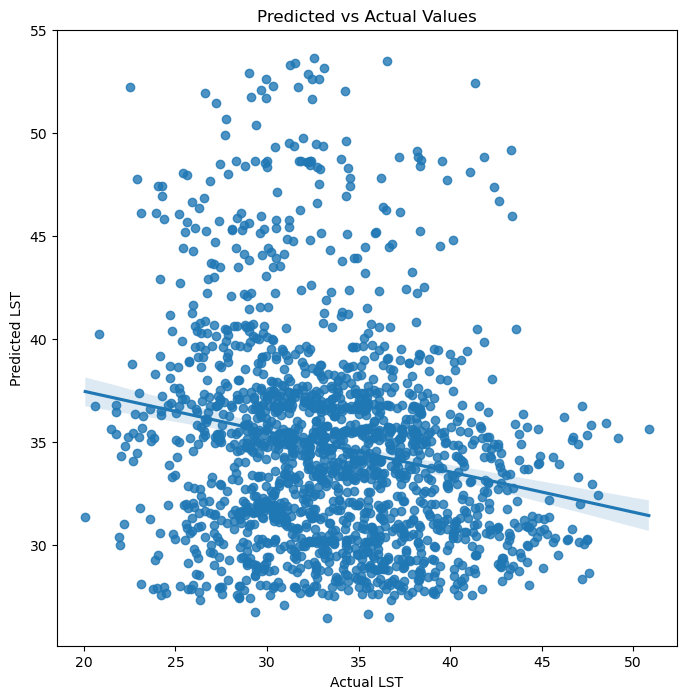

In [37]:
def main():
    # Load and preprocess data
    df = load_data('Daily Data (1).csv')
    df = add_features(df, window_size=7)
    
    # Prepare data
    X, y, feature_scaler, target_scaler = normalize_data(df)
    X_seq, y_seq = create_sequences(X, y, seq_length=30)
    
    # Train-test split (time-series aware)
    split_idx = int(0.8 * len(X_seq))
    X_train, y_train = X_seq[:split_idx], y_seq[:split_idx]
    X_test, y_test = X_seq[split_idx:], y_seq[split_idx:]
    
    # Further split train into train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, shuffle=False)
    
    # Create datasets and dataloaders
    train_dataset = LSTDataset(X_train, y_train)
    val_dataset = LSTDataset(X_val, y_val)
    test_dataset = LSTDataset(X_test, y_test)
    
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    input_size = X_train.shape[2]  # Number of features
    model = LSTPredictionModel(input_size, hidden_size=128, num_layers=2, dropout=0.3)
    
    # Train model
    trained_model, history = train_model(
        model, train_loader, val_loader, epochs=200, patience=15)
    
    # Plot training history
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Evaluate on test set
    y_true, y_pred = evaluate_model(trained_model, test_loader, target_scaler)

if __name__ == '__main__':
    main()